[View in Colaboratory](https://colab.research.google.com/github/eurismarpires/colab_test/blob/master/music_lstm.ipynb)

In [1]:
!ls

datalab


In [2]:
!pip install mido

    100% |████████████████████████████████| 71kB 2.4MB/s 


In [3]:
!git clone https://github.com/llSourcell/Music_Generator_Demo.git

Cloning into 'Music_Generator_Demo'...
remote: Counting objects: 218, done.
remote: Total 218 (delta 0), reused 0 (delta 0), pack-reused 218
Receiving objects: 100% (218/218), 66.15 KiB | 3.15 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [4]:
!ls Music_Generator_Demo/Pop_Music_Midi/

All The Small Things - Chorus.midi
All The Small Things - Verse.midi
Around The World - Chorus.midi
Around The World - Verse.midi
Baby I'm Yours - Chorus.midi
Baby One More Time - Chorus.midi
Baby One More Time - Verse.midi
Barbie Girl - Chorus.midi
Barbie Girl - Verse.midi
Beautiful Life - Chorus.midi
Beautiful Life - Pre Chorus.midi
Beautiful Life - Verse.midi
Best Day Of My Life - Chorus.midi
Blank Space - Chorus.midi
Blank Space - Pre Chorus.midi
Blank Space - Verse.midi
California Gurls - Chorus.midi
California Gurls - Pre Chorus.midi
California Gurls - Verse.midi
Call Me Maybe - Chorus.midi
Can You Feel the Love Tonight - Chorus.midi
Can You Feel the Love Tonight - Verse.midi
Chasing Pavements - Chorus.midi
Clocks - Intro.midi
Clocks - Verse.midi
Dancing Queen - Chorus.midi
Dancing Queen - Verse.midi
Dark Horse - Chorus.midi
Dark Horse - Verse.midi
Die Young - Chorus.midi
Die Young - Verse.midi
Don't Trust Me - Chorus.midi
Everybody - Chorus.midi
Every Time We Touch - Chorus.midi

**Preparação dos Dados**

In [0]:
from mido import MidiFile, Message, MetaMessage, MidiTrack
from math import ceil
import os
import numpy as np
from sklearn.utils import shuffle


#Global parameters
time_per_time_slice = 0.02 #0.02 #200ms #time-unit for each column in the piano roll
highest_note = 81 #81 # A_6
lowest_note = 33  #33 # A_2
input_dim = highest_note - lowest_note + 1 #highest_note - lowest_note + 1
output_dim = highest_note - lowest_note + 1 #highest_note - lowest_note + 1
MICROSECONDS_PER_MINUTE = 60000000 #60000000

In [0]:
def midiToPianoroll(filepath, debug = False):
	midi_data = MidiFile(filepath)
	resolution = midi_data.ticks_per_beat
	if debug:
		print ("resolution", resolution)
	set_tempo_events = [x for t in midi_data.tracks for x in t if str(x.type) == 'set_tempo']
	
	tempo = MICROSECONDS_PER_MINUTE/set_tempo_events[0].tempo
	if debug:
		print ("tempo", tempo)
	ticks_per_time_slice = 1.0 * (resolution * tempo * time_per_time_slice)/60 
	if debug:
		print ("ticks_per_time_slice", ticks_per_time_slice)
	
	#Get maximum ticks across all tracks
	total_ticks =0
	for t in midi_data.tracks:
        #since ticks represent delta times we need a cumulative sum to get the total ticks in that track
		sum_ticks = 0
		for e in t:
			if str(e.type) == 'note_on' or str(e.type) == 'note_off' or str(e.type) == 'end_of_track':
				sum_ticks += e.time
				
		if sum_ticks > total_ticks:
			total_ticks = sum_ticks
	if debug:
		print ("total_ticks", total_ticks)

	time_slices = int(ceil(total_ticks / ticks_per_time_slice))
	if debug:
		print ("time_slices", time_slices)

	piano_roll = np.zeros((input_dim, time_slices), dtype =int)

	note_states = {}
	for track in midi_data.tracks:
		total_ticks = 0
		for event in track:
			if str(event.type) == 'note_on' and event.velocity > 0:
				total_ticks += event.time
				time_slice_idx = int(total_ticks / ticks_per_time_slice )

				if event.note <= highest_note and event.note >= lowest_note: 
					note_idx = event.note - lowest_note
					piano_roll[note_idx][time_slice_idx] = 1
					note_states[note_idx] = time_slice_idx

			elif str(event.type) == 'note_off' or ( str(event.type) == 'note_on' and event.velocity == 0 ):
				note_idx = event.note - lowest_note
				total_ticks += event.time
				time_slice_idx = int(total_ticks /ticks_per_time_slice )

				if note_idx in note_states:	
					last_time_slice_index = note_states[note_idx]
					piano_roll[note_idx][last_time_slice_index:time_slice_idx] = 1
					del note_states[note_idx]
	return piano_roll.T

In [0]:
#preprocess data directory
def get_data(data_dir):
	pianoroll_data = []
	for file in os.listdir(data_dir):
		filepath = data_dir + "/" + file
		piano_roll = midiToPianoroll(filepath)
		pianoroll_data.append(piano_roll)

	return pianoroll_data

In [0]:
dataset_folder = 'Music_Generator_Demo/Pop_Music_Midi/'
pianoroll_data = get_data(dataset_folder)

In [9]:
len(pianoroll_data)

126

In [0]:
def createSeqNetInputs(pianoroll_data, x_seq_length, y_seq_length):
	x = []
	y = []

	for i,piano_roll in enumerate(pianoroll_data):
		print ("piano_roll.shape", piano_roll.shape)
		
		pos = 0
		while pos + x_seq_length + y_seq_length < piano_roll.shape[0]:
			x.append(piano_roll[pos:pos + x_seq_length])
			y.append(piano_roll [pos+ x_seq_length: pos + x_seq_length + y_seq_length])
			pos += x_seq_length

	X = np.array(x)
	Y = np.array(y)
	print ("x shape", X.shape)
	print ("y shape", Y.shape)

	x_1, y_1 = shuffle(X,Y)

	return x_1, y_1

In [0]:
x_seq_length = 50
y_seq_length = 50 

In [12]:
input_data, target_data = createSeqNetInputs(pianoroll_data, x_seq_length, y_seq_length)
input_data = input_data.astype(np.bool)
target_data = target_data.astype(np.bool)

piano_roll.shape (1600, 49)
piano_roll.shape (800, 49)
piano_roll.shape (400, 49)
piano_roll.shape (800, 49)
piano_roll.shape (1399, 49)
piano_roll.shape (1150, 49)
piano_roll.shape (1100, 49)
piano_roll.shape (1200, 49)
piano_roll.shape (1600, 49)
piano_roll.shape (800, 49)
piano_roll.shape (800, 49)
piano_roll.shape (800, 49)
piano_roll.shape (400, 49)
piano_roll.shape (900, 49)
piano_roll.shape (775, 49)
piano_roll.shape (800, 49)
piano_roll.shape (800, 49)
piano_roll.shape (800, 49)
piano_roll.shape (2000, 49)
piano_roll.shape (1600, 49)
piano_roll.shape (798, 49)
piano_roll.shape (2400, 49)
piano_roll.shape (799, 49)
piano_roll.shape (800, 49)
piano_roll.shape (800, 49)
piano_roll.shape (400, 49)
piano_roll.shape (1000, 49)
piano_roll.shape (600, 49)
piano_roll.shape (2000, 49)
piano_roll.shape (800, 49)
piano_roll.shape (400, 49)
piano_roll.shape (400, 49)
piano_roll.shape (1600, 49)
piano_roll.shape (3200, 49)
piano_roll.shape (800, 49)
piano_roll.shape (1600, 49)
piano_roll.sha

In [13]:
input_data.shape

(2496, 50, 49)

In [14]:
target_data.shape

(2496, 50, 49)

**Modelo**

In [15]:
from keras.models import Sequential
from keras.layers import LSTM,BatchNormalization,Dropout,RepeatVector,TimeDistributed, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
num_units =64
batch_size = 64
num_epochs = 100

In [17]:
model = Sequential()
model.add(LSTM(input_shape = (None,input_dim), output_dim = num_units, activation= 'tanh', return_sequences = True ))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(num_units, activation= 'tanh'))

	#decoder
model.add(RepeatVector(y_seq_length))
num_layers= 2
for _ in range(num_layers):
	model.add(LSTM(num_units, activation= 'tanh', return_sequences = True))
	model.add(BatchNormalization())
	model.add(Dropout(0.3))

model.add(TimeDistributed(Dense(output_dim, activation= 'softmax')))
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_shape=(None, 49), activation="tanh", return_sequences=True, units=64)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 64)          29184     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 64)            33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 64)            256       
__________

In [0]:
loss_function = 'categorical_crossentropy' #'categorical_crossentropy'
optimizer = Adam(lr=0.0001) #Adam() #lr=0.0001

In [0]:
model.compile(loss=loss_function, optimizer = optimizer)

In [0]:
earlystop = EarlyStopping(monitor='loss', patience= 50, min_delta = 0.01 , verbose=0, mode= 'auto') 
history = History()

In [153]:
hist = model.fit(input_data, target_data, batch_size =  batch_size, epochs=300, callbacks=[ earlystop, history ])
#hist = model.fit(input_data, target_data, batch_size =  batch_size, epochs=300, callbacks=[history ])
print("History:", hist.history )

Epoch 1/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7099
Epoch 2/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7014
Epoch 3/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6733
Epoch 4/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6802
Epoch 5/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6777
Epoch 6/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7113
Epoch 7/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6800
Epoch 8/300
 576/2496 [=====>........................] - ETA: 13s - loss: 8.6397

2496/2496 [==============================] - 17s 7ms/step - loss: 8.6517
Epoch 9/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7039
Epoch 10/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7122
Epoch 11/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7423
Epoch 12/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6901
Epoch 13/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7065
Epoch 14/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6766
Epoch 15/300
 896/2496 [=========>....................] - ETA: 10s - loss: 8.6314

2496/2496 [==============================] - 17s 7ms/step - loss: 8.6738
Epoch 16/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6953
Epoch 17/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.7006
Epoch 18/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.7061
Epoch 19/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6669
Epoch 20/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6741
Epoch 21/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6723
Epoch 22/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.7017

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6686
Epoch 23/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6987
Epoch 24/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.7030
Epoch 25/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6951
Epoch 26/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6609
Epoch 27/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.7007
Epoch 28/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6584
Epoch 29/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.5935

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6538
Epoch 30/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6430
Epoch 31/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6757
Epoch 32/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6732
Epoch 33/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6841
Epoch 34/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6602
Epoch 35/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6588
Epoch 36/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.6236

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6516
Epoch 37/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6519
Epoch 38/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6378
Epoch 39/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6220
Epoch 40/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6747
Epoch 41/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6510
Epoch 42/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6509
Epoch 43/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.6070

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6445
Epoch 44/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6640
Epoch 45/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6327
Epoch 46/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6599
Epoch 47/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6398
Epoch 48/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6482
Epoch 49/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6571
Epoch 50/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.5124

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6723
Epoch 51/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6533
Epoch 52/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6416
Epoch 53/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6654
Epoch 54/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6481
Epoch 55/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6397
Epoch 56/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6591
Epoch 57/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.5616

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6640
Epoch 58/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6521
Epoch 59/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6211
Epoch 60/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6556
Epoch 61/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6218
Epoch 62/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6383
Epoch 63/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6600
Epoch 64/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.5280

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6242
Epoch 65/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6386
Epoch 66/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6371
Epoch 67/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6088
Epoch 68/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6584
Epoch 69/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6397
Epoch 70/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6468
Epoch 71/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.4858

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6212
Epoch 72/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6366
Epoch 73/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6364
Epoch 74/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6158
Epoch 75/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6186
Epoch 76/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5947
Epoch 77/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6410
Epoch 78/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.7105

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6391
Epoch 79/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6072
Epoch 80/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6347
Epoch 81/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6240
Epoch 82/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6054
Epoch 83/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6056
Epoch 84/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6074
Epoch 85/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.6782

2496/2496 [==============================] - 17s 7ms/step - loss: 8.6558
Epoch 86/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5871
Epoch 87/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6021
Epoch 88/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6100
Epoch 89/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5951
Epoch 90/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6069
Epoch 91/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6143
Epoch 92/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.5503

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6202
Epoch 93/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6416
Epoch 94/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6146
Epoch 95/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6163
Epoch 96/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6196
Epoch 97/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6267
Epoch 98/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6150
Epoch 99/300
 896/2496 [=========>....................] - ETA: 11s - loss: 8.7050

2496/2496 [==============================] - 18s 7ms/step - loss: 8.6885
Epoch 100/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6191
Epoch 101/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5696
Epoch 102/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6074
Epoch 103/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5903
Epoch 104/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6022
Epoch 105/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6286
Epoch 106/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.5740

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5822
Epoch 107/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6045
Epoch 108/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5948
Epoch 109/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5819
Epoch 110/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5996
Epoch 111/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5860
Epoch 112/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5697
Epoch 113/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.6040

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5662
Epoch 114/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6171
Epoch 115/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.6222
Epoch 116/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5889
Epoch 117/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5998
Epoch 118/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5836
Epoch 119/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5903
Epoch 120/300
 768/2496 [========>.....................] - ETA: 11s - loss: 8.6340

2496/2496 [==============================] - 17s 7ms/step - loss: 8.6013
Epoch 121/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5708
Epoch 122/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5971
Epoch 123/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5881
Epoch 124/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5629
Epoch 125/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5867
Epoch 126/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5739
Epoch 127/300
 768/2496 [========>.....................] - ETA: 11s - loss: 8.4413

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5551
Epoch 128/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5783
Epoch 129/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5725
Epoch 130/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5658
Epoch 131/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5572
Epoch 132/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.6078
Epoch 133/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5690
Epoch 134/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.6218

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5712
Epoch 135/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5883
Epoch 136/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5545
Epoch 137/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5821
Epoch 138/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5912
Epoch 139/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5524
Epoch 140/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5518
Epoch 141/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.6767

2496/2496 [==============================] - 18s 7ms/step - loss: 8.5738
Epoch 142/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5519
Epoch 143/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5387
Epoch 144/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5340
Epoch 145/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5173
Epoch 146/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5491
Epoch 147/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5353
Epoch 148/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.4763

2496/2496 [==============================] - 18s 7ms/step - loss: 8.5547
Epoch 149/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5325
Epoch 150/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5449
Epoch 151/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5604
Epoch 152/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5410
Epoch 153/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5505
Epoch 154/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5636
Epoch 155/300
 768/2496 [========>.....................] - ETA: 11s - loss: 8.5657

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5291
Epoch 156/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5461
Epoch 157/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5429
Epoch 158/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5510
Epoch 159/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5394
Epoch 160/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5078
Epoch 161/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5403
Epoch 162/300
 768/2496 [========>.....................] - ETA: 11s - loss: 8.5680

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5220
Epoch 163/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5202
Epoch 164/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5536
Epoch 165/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5269
Epoch 166/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5525
Epoch 167/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5431
Epoch 168/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5474
Epoch 169/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.3905

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5548
Epoch 170/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5419
Epoch 171/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5186
Epoch 172/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5278
Epoch 173/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5235
Epoch 174/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5264
Epoch 175/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5110
Epoch 176/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.4959

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5175
Epoch 177/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5081
Epoch 178/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5168
Epoch 179/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5198
Epoch 180/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5372
Epoch 181/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5503
Epoch 182/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5306
Epoch 183/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.4993

2496/2496 [==============================] - 18s 7ms/step - loss: 8.5300
Epoch 184/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5005
Epoch 185/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5107
Epoch 186/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5201
Epoch 187/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5007
Epoch 188/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5420
Epoch 189/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5627
Epoch 190/300
 768/2496 [========>.....................] - ETA: 11s - loss: 8.5504

2496/2496 [==============================] - 17s 7ms/step - loss: 8.5479
Epoch 191/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5113
Epoch 192/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5122
Epoch 193/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5148
Epoch 194/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.4712
Epoch 195/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.4948
Epoch 196/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.4993
Epoch 197/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.5459

2496/2496 [==============================] - 18s 7ms/step - loss: 8.4871
Epoch 198/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5024
Epoch 199/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5519
Epoch 200/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.5926
Epoch 201/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.4875
Epoch 202/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.4928
Epoch 203/300
2496/2496 [==============================] - 17s 7ms/step - loss: 8.4968
Epoch 204/300
 768/2496 [========>.....................] - ETA: 12s - loss: 8.4334

2496/2496 [==============================] - 18s 7ms/step - loss: 8.5025
Epoch 205/300
2496/2496 [==============================] - 18s 7ms/step - loss: 8.5176
Epoch 206/300


KeyboardInterrupt: ignored

In [0]:
model.save_weights("model.h5")

In [126]:
print("History:", hist.history )

History: {'loss': [9.091264602465507, 9.077885529933832, 9.061925374544584, 9.088777957818447, 9.096061657636593, 9.098533190213717, 9.086993070749136, 9.093432401999449, 9.064432510962853, 9.064065786508413, 9.075973168397562, 9.065588926657652, 9.071618813734789, 9.057363656850962, 9.027721796280298, 9.073285836439867, 9.058489481608072, 9.083915148025904, 9.057693041287935, 9.036016977750338, 9.048761196625538, 9.055905880072178, 9.043162370339418, 9.00322486192752, 9.07244557600755, 8.999951215890738, 9.050137593195988, 9.056245950552134, 9.002696257371168, 9.027058112315643, 9.019765315911709, 9.026924377832657, 9.040553068503355, 9.024553078871508, 9.00793914305858, 9.033113308441944, 9.054161022870968, 9.040352870256473, 9.027462323506674, 9.000483684050732, 9.011246289962378, 9.00329223045936, 9.016948797763922, 8.98748412499061, 9.011411520150991, 9.007215964488495, 9.010597571348532, 8.976527874286358, 9.015610792698004, 8.991001911652393, 8.975697395129082, 8.972223942096416

In [127]:
print(hist.history.keys())

dict_keys(['loss'])


In [0]:
import matplotlib.pyplot as plt

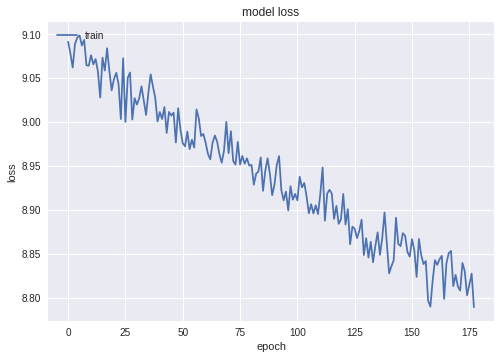

In [129]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [121]:
!ls

datalab			     midi		   readme.pdf
infographics		     model.h5		   scale_chords_small.zip
LSTM_gen_20180601_12_04.mid  model.json		   scale_chords_small.zip.1
LSTM_gen_20180601_14_41.mid  Music_Generator_Demo


In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [83]:
!cat model.json

{"class_name": "Sequential", "config": [{"class_name": "LSTM", "config": {"name": "lstm_1", "trainable": true, "batch_input_shape": [null, null, 49], "dtype": "float32", "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 64, "activation": "tanh", "recurrent_activation": "hard_sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 1}}, {"class_name": "BatchNormalization", "config"

**Geração**

In [0]:
model2 = Sequential()

In [0]:
model2 = model_from_json(open('model.json').read())

In [86]:
!ls

datalab			     midi	 Music_Generator_Demo
infographics		     model.h5	 readme.pdf
LSTM_gen_20180601_12_04.mid  model.json  scale_chords_small.zip


In [0]:
model2.load_weights('model.h5')

In [88]:
!ls

datalab			     midi	 Music_Generator_Demo
infographics		     model.h5	 readme.pdf
LSTM_gen_20180601_12_04.mid  model.json  scale_chords_small.zip


In [89]:
!wget http://www.feelyoursound.com/data/scale_chords_small.zip

--2018-06-01 13:49:46--  http://www.feelyoursound.com/data/scale_chords_small.zip
Resolving www.feelyoursound.com (www.feelyoursound.com)... 81.169.145.164, 2a01:238:20a:202:1164::
Connecting to www.feelyoursound.com (www.feelyoursound.com)|81.169.145.164|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.feelyoursound.com/data/scale_chords_small.zip [following]
--2018-06-01 13:49:46--  https://www.feelyoursound.com/data/scale_chords_small.zip
Connecting to www.feelyoursound.com (www.feelyoursound.com)|81.169.145.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6388682 (6.1M) [application/zip]
Saving to: ‘scale_chords_small.zip.1’

scale_chords_small. 100%[===================>]   6.09M  6.03MB/s    in 1.0s    

2018-06-01 13:49:47 (6.03 MB/s) - ‘scale_chords_small.zip.1’ saved [6388682/6388682]



In [90]:
!unzip scale_chords_small.zip

Archive:  scale_chords_small.zip
replace infographics/chords_asharp_aeolian.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [91]:
!ls

datalab			     model.h5		   scale_chords_small.zip
infographics		     model.json		   scale_chords_small.zip.1
LSTM_gen_20180601_12_04.mid  Music_Generator_Demo
midi			     readme.pdf


In [0]:
dataset_folder = 'midi'

In [0]:
import glob

In [0]:
midi_files  = glob.glob(dataset_folder +'/*.mid')

In [0]:
import random

In [96]:
len(midi_files)

156

In [0]:
file_idx = random.randint(0,len(midi_files) - 1) # escolhe um arquivo mid aleatório

In [132]:
file_idx

60

In [0]:
primer = midi_files[file_idx]

In [134]:
primer

'midi/scale_gsharp_major.mid'

In [0]:
test_piano_roll = midiToPianoroll(primer)

In [136]:
test_piano_roll.shape

(2850, 49)

In [0]:
test_data = [test_piano_roll]

In [0]:
#create Network inputs
def createSeqTestNetInputs(pianoroll_data, seq_length):
	x_test = []
	
	for i,piano_roll in enumerate(pianoroll_data):
		print ("piano_roll.shape", piano_roll.shape)
		x = []
		pos = 0
		while pos + seq_length < piano_roll.shape[0]:
			x.append(piano_roll[pos:pos + seq_length])
			pos +=1
		x_test.append(np.array(x))

	print("x_test shape", np.array(x_test).shape)

	return np.array(x_test)

In [139]:
test_input = createSeqTestNetInputs(test_data, x_seq_length)

piano_roll.shape (2850, 49)
x_test shape (1, 2800, 50, 49)


In [0]:
import time

In [0]:
generated_file = 'LSTM_gen_%s.mid' %(time.strftime("%Y%m%d_%H_%M"))

In [142]:
print(generated_file)

LSTM_gen_20180601_18_25.mid


In [0]:
def seqNetOutToPianoroll(output, threshold = 0.1):
	piano_roll = []
	for seq_out in output:
		for time_slice in seq_out:
			idx = [i for i,t in enumerate(time_slice) if t > threshold]
			pianoroll_slice = np.zeros(time_slice.shape)
			pianoroll_slice[idx] = 1
			piano_roll.append(pianoroll_slice)

	return np.array(piano_roll)

In [0]:
# pianoroll to MIDI
def pianorollToMidi(piano_roll, filepath):
    #ensure that resolution is an integer 
	ticks_per_time_slice=1 # hard-coded, arbitrary but needs to be >= 1 and an integer to avoid distortion
	tempo = 1/time_per_time_slice
	resolution = 60*ticks_per_time_slice/(tempo*time_per_time_slice)

	mid = MidiFile(ticks_per_beat = int(resolution))
	track = MidiTrack()
	mid.tracks.append(track)
	track.append(MetaMessage('set_tempo', tempo = int(MICROSECONDS_PER_MINUTE/tempo), time =0))

	current_state = np.zeros(input_dim)

	index_of_last_event = 0

	for slice_index, time_slice in enumerate(np.concatenate((piano_roll, np.zeros((1, input_dim))), axis =0)):
		note_changes = time_slice - current_state
		
		for note_idx, note in enumerate(note_changes):
			if note == 1:
				note_event = Message('note_on', time = (slice_index - index_of_last_event)*ticks_per_time_slice, velocity = 65, note = note_idx + lowest_note )
				track.append(note_event)
				index_of_last_event = slice_index
			elif note == -1:
				note_event = Message('note_off', time = (slice_index - index_of_last_event)*ticks_per_time_slice, velocity = 65, note = note_idx + lowest_note )
				track.append(note_event)
				index_of_last_event = slice_index

		current_state = time_slice

	eot = MetaMessage('end_of_track', time=1)
	track.append(eot)
	
	mid.save(filepath)

In [145]:
for i,song in enumerate(test_input):
  net_output = model.predict(song)
  print("net_output:", np.array(net_output.shape))
  net_roll = seqNetOutToPianoroll(net_output)
  print("net_roll:", net_roll.shape)
  pianorollToMidi(net_roll, generated_file)
    

net_output: [2800   50   49]
net_roll: (140000, 49)


In [146]:
!ls

datalab			     model.h5
infographics		     model.json
LSTM_gen_20180601_12_04.mid  Music_Generator_Demo
LSTM_gen_20180601_14_41.mid  readme.pdf
LSTM_gen_20180601_18_25.mid  scale_chords_small.zip
midi			     scale_chords_small.zip.1


In [0]:
from google.colab import files
files.download(generated_file)  # from colab to browser download

In [0]:
from google.colab import files
files.download('model.h5')  # from colab to browser download